In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cudf
import cupy as cp
import numpy as np
import random

class PatientDataEnv:
    def __init__(self, base_file):
        self.base_data = cudf.read_csv(base_file)
        if 'Reward' not in self.base_data.columns:
            raise ValueError("Base data must contain a 'Reward' column")
        self.base_data['Patient ID'] = self.base_data['Patient ID'].astype(str)
        self.attributes = ['Patient ID', 'Age', 'Sex', 'Medical History', 
                           'Exercise Frequency', 'Preferred Exercise', 'Exercise Duration',
                           'Race', 'Weekly Goal', 'Strength Training', 'Start Preference',
                           'Exercise Variety', 'Exercise Location', 'Exercise Buddy',
                           'Cardio Preference', 'Strength Preference', 'Coach Appearance']
        self.state = self.reset()
        self.observation_space = len(self.attributes)
        
    def reset(self):
        self.state = {
            'Patient ID': str(random.randint(1000, 9999)),
            'Age': random.randint(18, 65),
            'Sex': random.choice(['Male', 'Female', 'Non-Binary', 'Prefer not to say']),
            'Medical History': random.choice(['diabetes', 'hypertension', 'COPD', 'high cholesterol', 'back pain', 'spondylitis',
                                 'none', 'obesity','kidney disease', 'osteoarthritis', 'stroke', 'cardiac disease', 'Alzheimer’s']),
            'Exercise Frequency': random.randint(1, 7),
            'Preferred Exercise': random.choice(['cardio', 'strength', 'flexibility']),
            'Exercise Duration': random.choice(['30-45', '45-60', '0-15', '15-30', '60-75', '75-90', '90-105', '105-120']),
            'Race': random.choice(['White', 'Black', 'Asian', 'Hispanic', 'Other']),
            'Weekly Goal': random.randint(90, 210),
            'Strength Training': random.randint(0, 1),
            'Start Preference': random.randint(0, 1),
            'Exercise Variety': random.randint(0, 1),
            'Exercise Location': random.randint(0, 4),
            'Exercise Buddy': random.randint(0, 1),
            'Cardio Preference': random.randint(1, 10),
            'Strength Preference': random.randint(0, 1),
            'Coach Appearance': random.randint(1, 4)
        }
        return self.state
    
    def step(self, action):
        attribute, value = action
        self.state[attribute] = value
        reward = self.calculate_reward()
        return self.state, reward
    
    def calculate_reward(self):
        subset_attributes = ['Age', 'Sex', 'Medical History', 'Preferred Exercise', 'Exercise Frequency', 'Exercise Duration']
        
        matches = cudf.Series([True] * len(self.base_data))
        for attr in subset_attributes:
            current_value = str(self.state[attr])
            matches &= (self.base_data[attr].astype(str) == current_value)
        
        matching_rows = self.base_data[matches]
        
        if len(matching_rows) > 0:
            reward = matching_rows['Reward'].iloc[0]
            return reward
        else:
            return 0.2


class QLearningAgent:
    def __init__(self, env, alpha=0.3, gamma=0.8, epsilon=0.5, epsilon_decay=0.99, min_epsilon=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = {}
        self.epsilon_history = []
    
    def get_q_value(self, state, action):
        state_str = str(state)
        if state_str not in self.q_table:
            self.q_table[state_str] = {}
        if action not in self.q_table[state_str]:
            self.q_table[state_str][action] = 0
        return self.q_table[state_str][action]
    
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            attribute = random.choice(list(self.env.state.keys()))
            if attribute == 'Exercise Frequency':
                value = random.randint(1, 7)
            elif attribute == 'Exercise Duration':
                value = random.choice(['30-45', '45-60', '0-15', '15-30', '60-75', '75-90', '90-105', '105-120'])
            elif attribute == 'Weekly Goal':
                value = random.randint(90, 210)
            elif attribute in ['Strength Training', 'Start Preference', 'Exercise Variety', 'Exercise Buddy']:
                value = random.randint(0, 1)
            elif attribute == 'Exercise Location':
                value = random.randint(0, 4)
            elif attribute == 'Cardio Preference':
                value = random.randint(1, 10)
            elif attribute == 'Strength Preference':
                value = random.randint(0, 1)
            elif attribute == 'Coach Appearance':
                value = random.randint(1,4)
            else:
                value = random.choice([self.env.state[attribute]])
            return (attribute, value)
        else:
            state_str = str(state)
            if state_str not in self.q_table or not self.q_table[state_str]:
                self.q_table[state_str] = {(attribute, value): 0 for attribute, value in self.env.state.items()}
            return max(self.q_table[state_str], key=self.q_table[state_str].get)
    
    def update_q_table(self, state, action, reward, next_state):
        state_str = str(state)
        best_next_action = self.choose_action(next_state)

        old_value = self.get_q_value(state, action)
        next_max = self.get_q_value(next_state, best_next_action)

        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table[state_str][action] = new_value
    
    def train(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            
            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward = self.env.step(action)
                
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                
                max_reward = self.env.base_data['Reward'].max()
                success_threshold = max_reward * 0.5
                
                if reward >= success_threshold:
                    done = True
                    break
            
            if done:
                self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            
            self.epsilon_history.append((episode, state['Patient ID'], self.epsilon))
            
            print(f"Episode {episode+1}/{episodes}, Patient ID: {state['Patient ID']}, Total Reward: {total_reward}, Epsilon: {self.epsilon}")
    
    def generate_synthetic_data(self, num_samples, max_steps_per_episode):
        def generate_sample():
            state = self.env.reset()
            total_reward = 0
            done = False
            
            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward = self.env.step(action)
                
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                
                max_reward = self.env.base_data['Reward'].max()
                success_threshold = max_reward * 0.5
                
                if reward >= success_threshold:
                    done = True
                    break
            
            return state, done
        
        samples = []
        while len(samples) < num_samples:
            state, done = generate_sample()
            if done:
                samples.append(state)
                print("added additional sample")
        
        return cudf.DataFrame(samples)  

# Usage 
env = PatientDataEnv('base_file_created_including guidelines.csv')
agent = QLearningAgent(env)
agent.train(episodes=1000, max_steps_per_episode=5)
synthetic_data = agent.generate_synthetic_data(num_samples=2000, max_steps_per_episode=5)
synthetic_data.to_csv('synthetic_data_generated_using_base_file_with_guidelines.csv', index=False)
print("Synthetic data has been saved to 'synthetic_data_generated_using_base_file_with_guidelines.csv'.")

# Plot epsilon decay
epsilon_history_df = pd.DataFrame(agent.epsilon_history, columns=['Episode', 'Patient ID', 'Epsilon'])
plt.figure(figsize=(10, 6))
plt.plot(epsilon_history_df['Episode'], epsilon_history_df['Epsilon'])
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')
plt.grid(True)
plt.show()

In [3]:
synthetic_data

,Patient ID,Age,Sex,Medical History,Exercise Frequency,Preferred Exercise,Exercise Duration,Race,Weekly Goal,Strength Training,Start Preference,Exercise Variety,Exercise Location,Exercise Buddy,Cardio Preference,Strength Preference,Coach Appearance
0,9286,22,Male,obesity,4,strength,90-105,Asian,205,1,0,0,3,0,6,0,2
1,5516,35,Non-Binary,back pain,3,flexibility,75-90,Other,199,0,1,1,4,1,6,1,1
2,1551,28,Non-Binary,Alzheimer’s,3,strength,75-90,Black,159,0,0,1,0,0,3,0,1
3,3128,36,Non-Binary,Alzheimer’s,5,flexibility,60-75,Black,114,0,0,0,2,0,6,0,4
4,8815,56,Prefer not to say,none,3,cardio,105-120,White,143,1,0,0,4,1,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1817,64,Prefer not to say,obesity,3,cardio,75-90,White,106,0,0,1,2,0,10,0,4
1996,4207,47,Male,obesity,4,cardio,75-90,Hispanic,197,1,1,1,0,0,4,1,4
1997,1064,26,Prefer not to say,obesity,5,cardio,45-60,White,208,0,1,1,4,1,7,1,1
1998,2572,42,Non-Binary,COPD,7,cardio,30-45,White,94,0,0,1,4,0,7,1,2


## Distribution comparison of updated synthetic data with base dataset

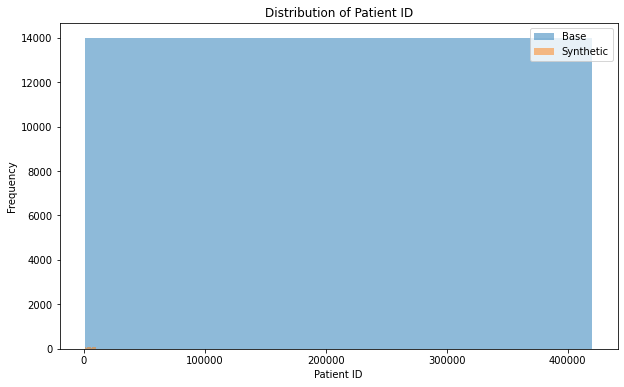

Distribution comparison for Patient ID:
Kruskal-Wallis H-test:
  Statistic: 5720.8232
  p-value: 0.0000
Kolmogorov-Smirnov test:
  Statistic: 0.9785
  p-value: 0.0000



/tmp/ipykernel_287654/3390027513.py:100: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=base[var], label='Base', shade=True)
/tmp/ipykernel_287654/3390027513.py:101: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=synthetic[var], label='Synthetic', shade=True)


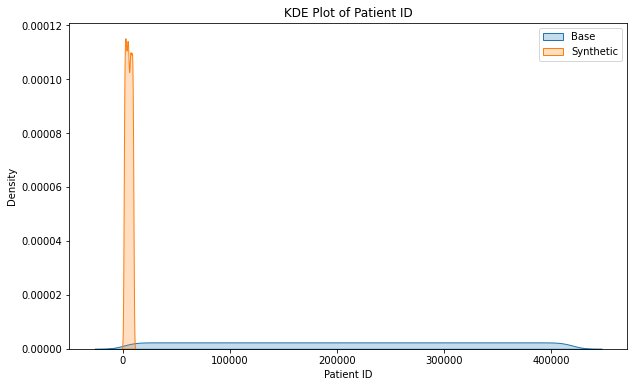

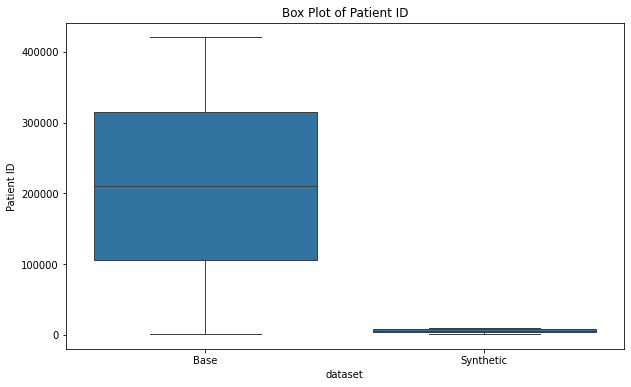

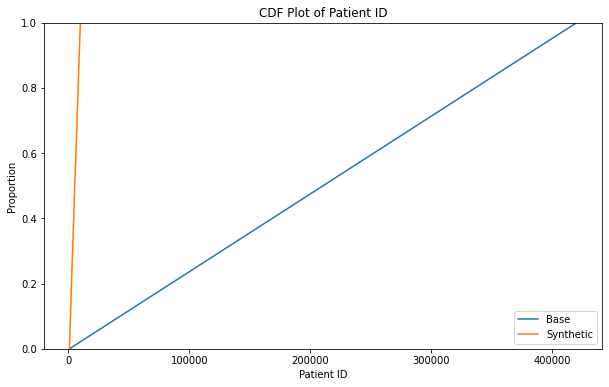

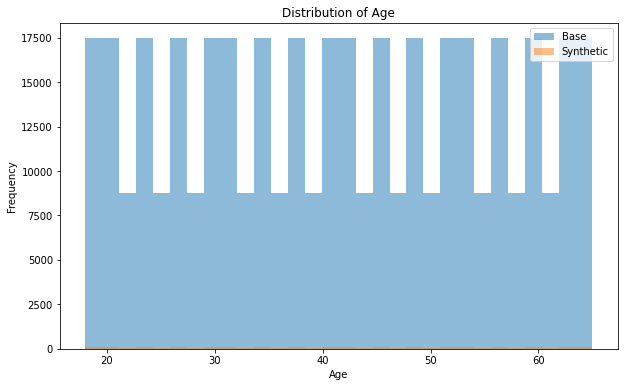

Distribution comparison for Age:
Kruskal-Wallis H-test:
  Statistic: 0.0302
  p-value: 0.8619
Kolmogorov-Smirnov test:
  Statistic: 0.0140
  p-value: 0.8246



/tmp/ipykernel_287654/3390027513.py:100: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=base[var], label='Base', shade=True)
/tmp/ipykernel_287654/3390027513.py:101: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=synthetic[var], label='Synthetic', shade=True)


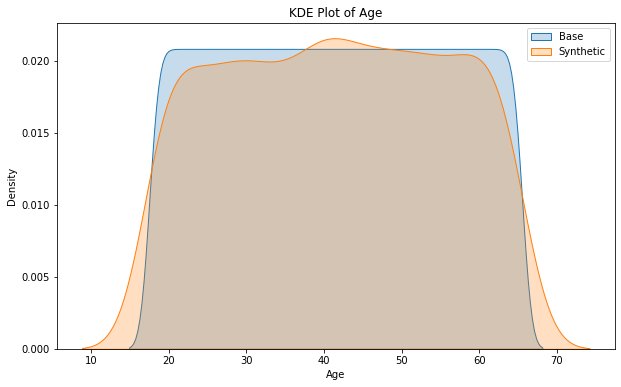

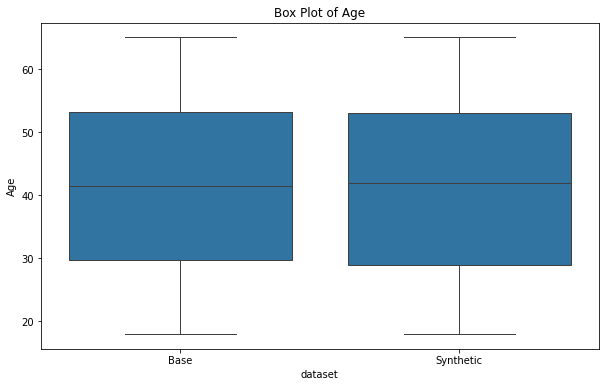

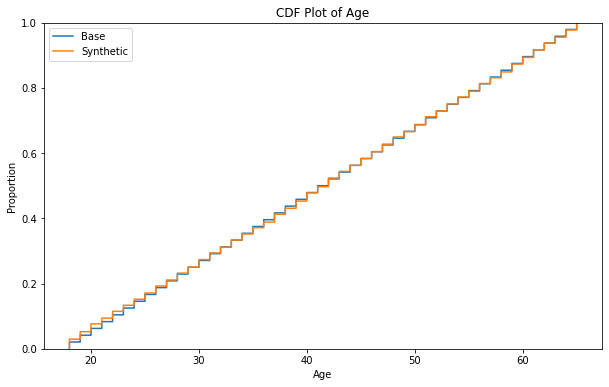

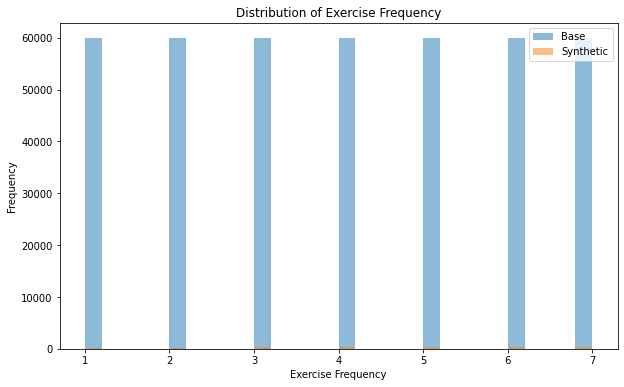

Distribution comparison for Exercise Frequency:
Kruskal-Wallis H-test:
  Statistic: 67.9409
  p-value: 0.0000
Kolmogorov-Smirnov test:
  Statistic: 0.0837
  p-value: 0.0000



/tmp/ipykernel_287654/3390027513.py:100: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=base[var], label='Base', shade=True)
/tmp/ipykernel_287654/3390027513.py:101: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=synthetic[var], label='Synthetic', shade=True)


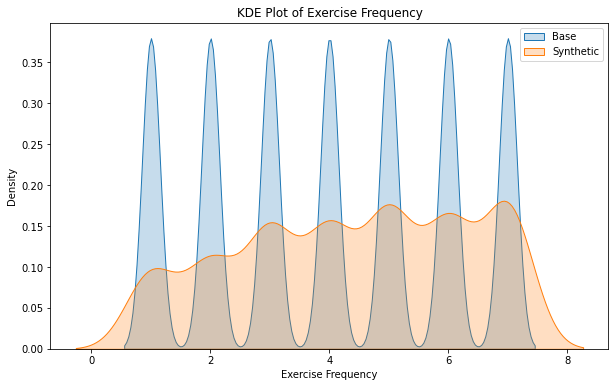

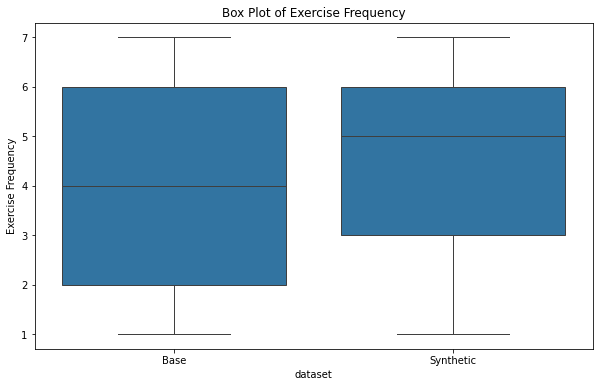

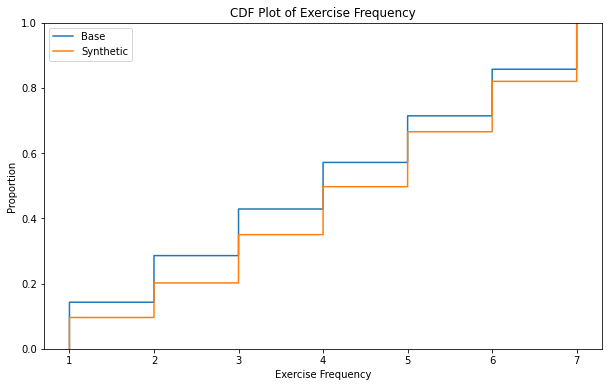

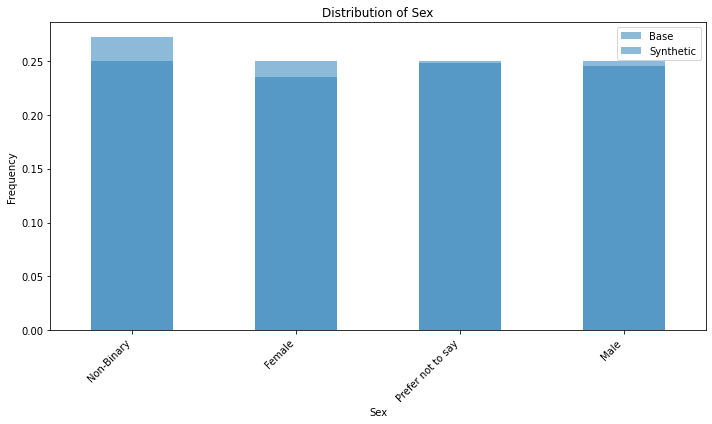

Distribution comparison for Sex:
Jensen-Shannon divergence: 0.0190



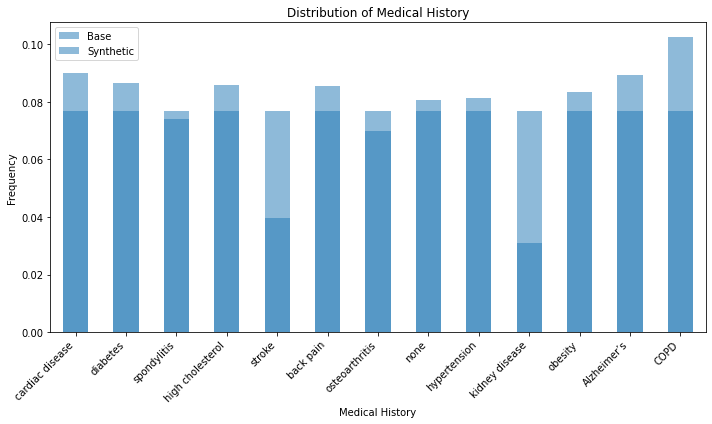

Distribution comparison for Medical History:
Jensen-Shannon divergence: 0.1006



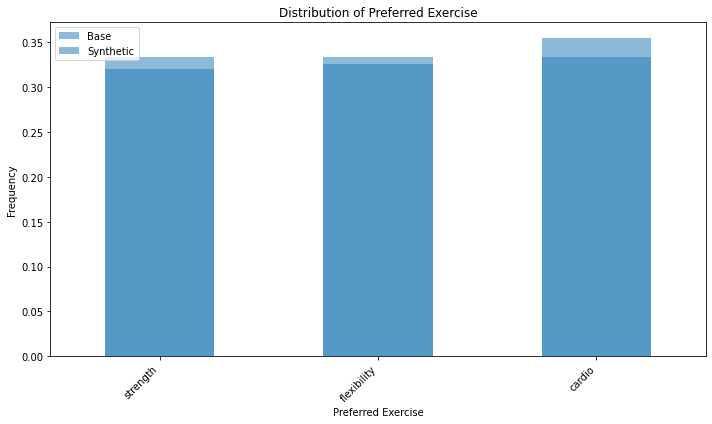

Distribution comparison for Preferred Exercise:
Jensen-Shannon divergence: 0.0159



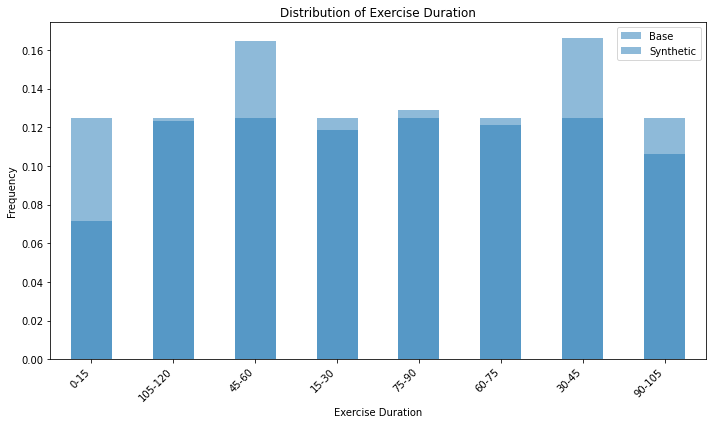

Distribution comparison for Exercise Duration:
Jensen-Shannon divergence: 0.0834



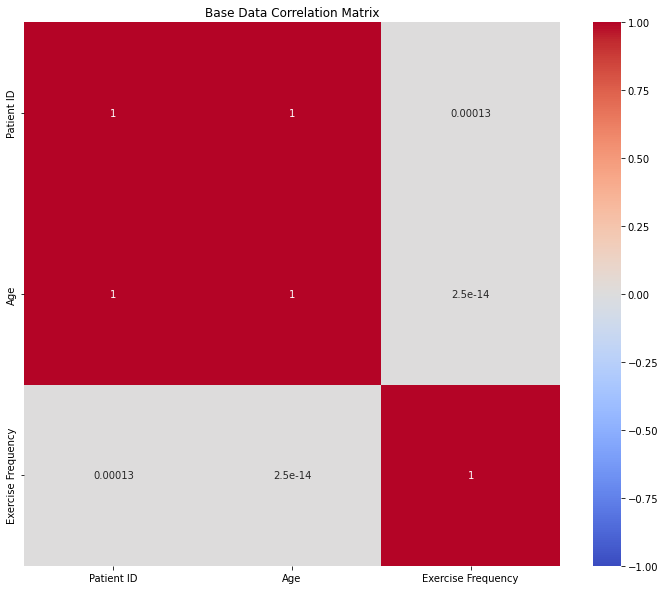

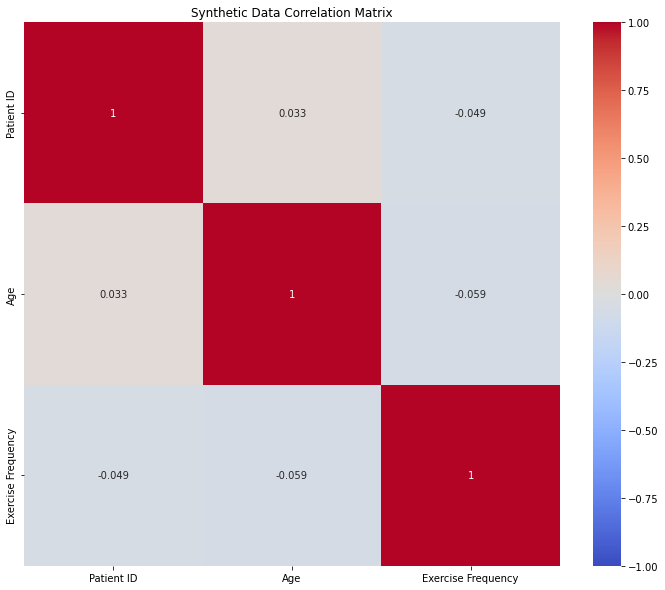

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the datasets
base_data = pd.read_csv('base_file_created_including guidelines.csv')
synthetic_data = pd.read_csv('synthetic_data_generated_using_base_file_with_guidelines.csv')

# Identify common variables
common_vars = [var for var in base_data.columns if var in synthetic_data.columns]

# Separate numerical and categorical variables
num_vars = base_data[common_vars].select_dtypes(include=['float64', 'int64']).columns
cat_vars = base_data[common_vars].select_dtypes(include=['object', 'category']).columns

def compare_numerical_distributions(base, synthetic, var):
    # Perform Kruskal-Wallis H-test
    kruskal_statistic, kruskal_p_value = stats.kruskal(base[var], synthetic[var])
    
    # Perform Kolmogorov-Smirnov test
    ks_statistic, ks_p_value = stats.ks_2samp(base[var], synthetic[var])
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(base[var], bins=30, alpha=0.5, label='Base')
    plt.hist(synthetic[var], bins=30, alpha=0.5, label='Synthetic')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    print(f"Distribution comparison for {var}:")
    print(f"Kruskal-Wallis H-test:")
    print(f"  Statistic: {kruskal_statistic:.4f}")
    print(f"  p-value: {kruskal_p_value:.4f}")
    print(f"Kolmogorov-Smirnov test:")
    print(f"  Statistic: {ks_statistic:.4f}")
    print(f"  p-value: {ks_p_value:.4f}\n")

def compare_categorical_distributions(base, synthetic, var):
    base_freq = base[var].value_counts(normalize=True)
    synthetic_freq = synthetic[var].value_counts(normalize=True)
    
    # Ensure both frequency distributions have the same categories
    all_categories = set(base_freq.index) | set(synthetic_freq.index)
    base_freq = base_freq.reindex(all_categories, fill_value=0)
    synthetic_freq = synthetic_freq.reindex(all_categories, fill_value=0)
    
    # Calculate Jensen-Shannon divergence
    js_divergence = jensenshannon(base_freq, synthetic_freq)
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    base_freq.plot(kind='bar', alpha=0.5, label='Base')
    synthetic_freq.plot(kind='bar', alpha=0.5, label='Synthetic')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"Distribution comparison for {var}:")
    print(f"Jensen-Shannon divergence: {js_divergence:.4f}\n")

def plot_correlation_matrix(data, title):
    corr = data[num_vars].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(title)
    plt.show()

def plot_pca(base, synthetic, title):
    scaler = StandardScaler()
    base_scaled = scaler.fit_transform(base[num_vars])
    synthetic_scaled = scaler.transform(synthetic[num_vars])
    
    pca = PCA(n_components=2)
    base_pca = pca.fit_transform(base_scaled)
    synthetic_pca = pca.transform(synthetic_scaled)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(base_pca[:, 0], base_pca[:, 1], alpha=0.5, label='Base')
    plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], alpha=0.5, label='Synthetic')
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.show()

def plot_kde(base, synthetic, var):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=base[var], label='Base', shade=True)
    sns.kdeplot(data=synthetic[var], label='Synthetic', shade=True)
    plt.title(f'KDE Plot of {var}')
    plt.xlabel(var)
    plt.legend()
    plt.show()

def plot_box(base, synthetic, var):
    plt.figure(figsize=(10, 6))
    data = pd.DataFrame({
        'value': pd.concat([base[var], synthetic[var]]),
        'dataset': ['Base']*len(base) + ['Synthetic']*len(synthetic)
    })
    sns.boxplot(x='dataset', y='value', data=data)
    plt.title(f'Box Plot of {var}')
    plt.ylabel(var)
    plt.show()

def plot_cdf(base, synthetic, var):
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(data=base[var], label='Base')
    sns.ecdfplot(data=synthetic[var], label='Synthetic')
    plt.title(f'CDF Plot of {var}')
    plt.xlabel(var)
    plt.legend()
    plt.show()

# Compare distributions for numerical variables
for var in num_vars:
    compare_numerical_distributions(base_data, synthetic_data, var)
    plot_kde(base_data, synthetic_data, var)
    plot_box(base_data, synthetic_data, var)
    plot_cdf(base_data, synthetic_data, var)

# Compare distributions for categorical variables
for var in cat_vars:
    compare_categorical_distributions(base_data, synthetic_data, var)

# Plot correlation matrices
plot_correlation_matrix(base_data, "Base Data Correlation Matrix")
plot_correlation_matrix(synthetic_data, "Synthetic Data Correlation Matrix")

## Calculate correlations between features

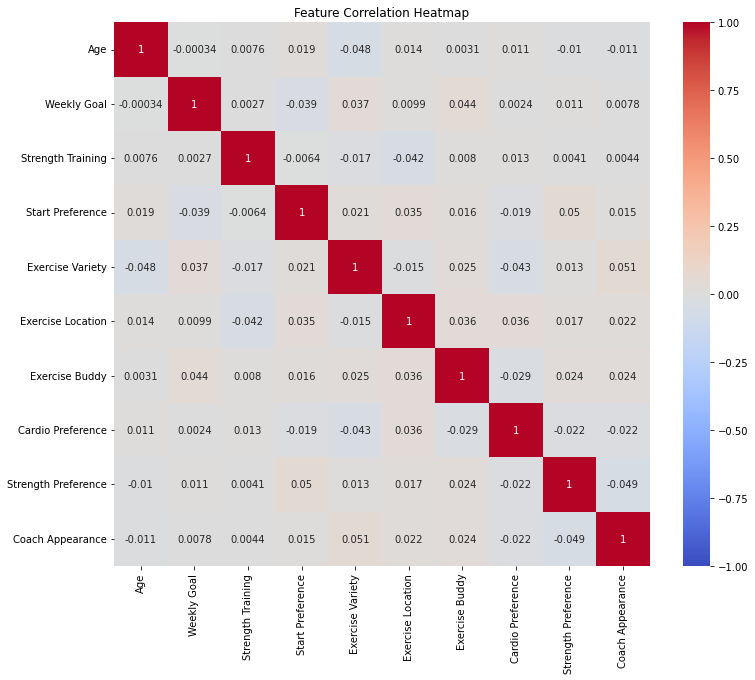

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

synthetic_data_for_recsys = pd.read_csv('synthetic_data_generated_using_base_file_with_guidelines.csv')

# Assuming synthetic_data_for_recsys is your DataFrame
numeric_data = synthetic_data_for_recsys[['Age', 'Weekly Goal', 'Strength Training', 'Start Preference', 
                                          'Exercise Variety', 'Exercise Location', 'Exercise Buddy', 
                                          'Cardio Preference', 'Strength Preference', 'Coach Appearance']]

# 1. Calculate correlations
correlation_matrix = numeric_data.corr()

# 2. Visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [7]:
# Identify strongly correlated features
def find_correlated_features(correlation_matrix, threshold=0.5):
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return list(correlated_features)

correlated_features = find_correlated_features(correlation_matrix)
print("Strongly correlated features:", correlated_features)

Strongly correlated features: []


In [8]:
def find_correlated_features(correlation_matrix, threshold=0.3):
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return list(correlated_features)

correlated_features = find_correlated_features(correlation_matrix)
print("Moderately correlated features:", correlated_features)

Moderately correlated features: []


### Evaluation of synthetic data generated using updated base file using logistic regression to check loss function of both datasets

Base data columns: Index(['Age', 'Sex', 'Medical History', 'Preferred Exercise',
       'Exercise Frequency', 'Exercise Duration', 'Reward', 'Patient ID'],
      dtype='object')
Synthetic data columns: Index(['Patient ID', 'Age', 'Sex', 'Medical History', 'Exercise Frequency',
       'Preferred Exercise', 'Exercise Duration', 'Race', 'Weekly Goal',
       'Strength Training', 'Start Preference', 'Exercise Variety',
       'Exercise Location', 'Exercise Buddy', 'Cardio Preference',
       'Strength Preference', 'Coach Appearance'],
      dtype='object')
Initial Performance on Base Data:
Log Loss: 0.2697
Accuracy: 0.8849
F1 Score (weighted): 0.8834

Top 10 Important Features:
                            feature  importance
16             Medical History_none    3.498396
18   Medical History_osteoarthritis    2.148894
8       Medical History_Alzheimer’s    2.148846
20           Medical History_stroke    2.148020
15   Medical History_kidney disease    2.145021
11  Medical History_cardiac d

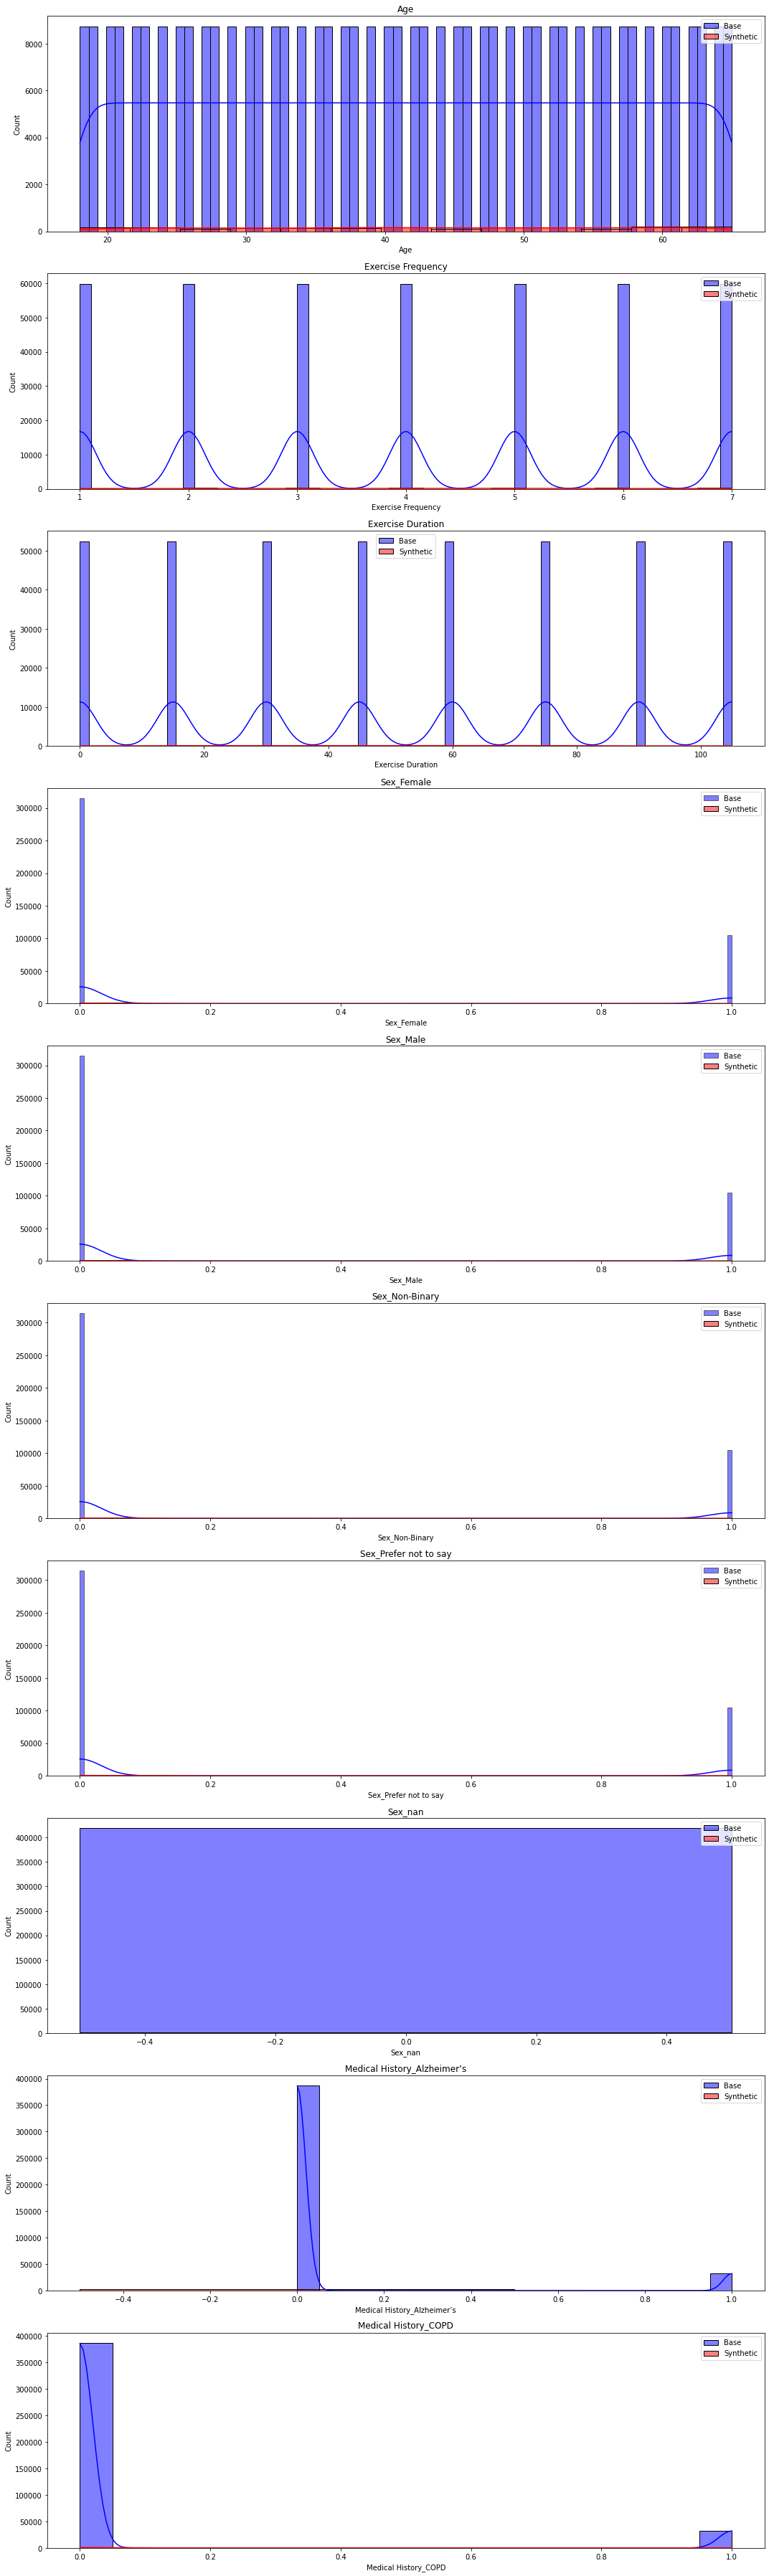

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the base and synthetic datasets
base_data = pd.read_csv('base_data_0722.csv')
synthetic_data = pd.read_csv('synthetic_data_generated_using_updated_base_data.csv')

# Print column names to verify
print("Base data columns:", base_data.columns)
print("Synthetic data columns:", synthetic_data.columns)

def prepare_data(df, reference_df=None):
    features = ['Age', 'Sex', 'Medical History', 'Preferred Exercise', 'Exercise Frequency', 'Exercise Duration']
    X = df[features]
    
    cat_columns = ['Sex', 'Medical History', 'Preferred Exercise']
    
    for col in cat_columns:
        if reference_df is not None:
            all_categories = set(X[col].unique()) | set(reference_df[col].unique())
        else:
            all_categories = set(X[col].unique())
        
        dummies = pd.get_dummies(X[col], prefix=col, dummy_na=True)
        
        for cat in all_categories:
            if f"{col}_{cat}" not in dummies.columns:
                dummies[f"{col}_{cat}"] = 0
        
        X = X.drop(col, axis=1)
        X = pd.concat([X, dummies], axis=1)
    
    # Handle 'Exercise Duration'
    def extract_first_number(s):
        match = re.search(r'\d+', str(s))
        return int(match.group()) if match else np.nan

    X['Exercise Duration'] = X['Exercise Duration'].apply(extract_first_number)
    
    # Fill missing values
    X['Age'] = X['Age'].fillna(X['Age'].mean())
    X['Exercise Frequency'] = X['Exercise Frequency'].fillna(X['Exercise Frequency'].mean())
    X['Exercise Duration'] = X['Exercise Duration'].fillna(X['Exercise Duration'].mean())
    
    return X

def evaluate_data(X, y, name, initial=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)
    y_pred = model.predict(X_test_scaled)
    
    loss = log_loss(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{'Initial' if initial else 'Final'} Performance on {name} Data:")
    print(f"Log Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print()
    
    if initial:
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': abs(model.coef_[0])
        }).sort_values('importance', ascending=False)
        
        print("Top 10 Important Features:")
        print(feature_importance.head(10))
        print()
    
    return model, scaler, loss, accuracy, f1

def evaluate_synthetic_data(X_synthetic, base_model, base_scaler):
    X_synthetic_scaled = base_scaler.transform(X_synthetic)
    y_pred = base_model.predict(X_synthetic_scaled)
    y_pred_proba = base_model.predict_proba(X_synthetic_scaled)
    
    # Calculate metrics
    synthetic_positive_rate = np.mean(y_pred)
    
    print("Performance on Synthetic Data:")
    print(f"Predicted Positive Rate: {synthetic_positive_rate:.4f}")
    
    if np.all(y_pred == y_pred[0]):
        print("Warning: All predictions are the same. Unable to calculate log loss.")
        synthetic_log_loss = None
    else:
        synthetic_log_loss = log_loss(y_pred, y_pred_proba)
        print(f"Log Loss: {synthetic_log_loss:.4f}")
    
    # Additional information
    print(f"Number of positive predictions: {np.sum(y_pred)}")
    print(f"Number of negative predictions: {len(y_pred) - np.sum(y_pred)}")
    
    return synthetic_positive_rate, synthetic_log_loss

# Prepare and evaluate base data
X_base = prepare_data(base_data)
if 'Reward' in base_data.columns:
    y_base = (base_data['Reward'] > base_data['Reward'].median()).astype(int)  # Convert to binary
    base_model, base_scaler, initial_loss, initial_accuracy, initial_f1 = evaluate_data(X_base, y_base, "Base")
else:
    print("Warning: 'Reward' column not found in base data. Skipping evaluation.")
    base_model, base_scaler, initial_loss, initial_accuracy, initial_f1 = None, None, None, None, None

# Prepare synthetic data using base data as reference
X_synthetic = prepare_data(synthetic_data, reference_df=base_data)

# Ensure X_synthetic has the same columns as X_base
for col in X_base.columns:
    if col not in X_synthetic.columns:
        X_synthetic[col] = 0

X_synthetic = X_synthetic[X_base.columns]

# Evaluate synthetic data
synthetic_positive_rate, synthetic_log_loss = evaluate_synthetic_data(X_synthetic, base_model, base_scaler)

# Compare feature distributions
print("Feature Distribution Comparison:")
for feature in ['Age', 'Exercise Frequency', 'Exercise Duration']:
    base_mean = X_base[feature].mean()
    base_std = X_base[feature].std()
    synthetic_mean = X_synthetic[feature].mean()
    synthetic_std = X_synthetic[feature].std()
    print(f"{feature}:")
    print(f"  Base: mean={base_mean:.2f}, std={base_std:.2f}")
    print(f"  Synthetic: mean={synthetic_mean:.2f}, std={synthetic_std:.2f}")
    print(f"  Difference: mean={abs(base_mean - synthetic_mean):.2f}, std={abs(base_std - synthetic_std):.2f}")
    print()

# Final evaluation on base data (if possible)
if 'Reward' in base_data.columns:
    _, _, final_loss, final_accuracy, final_f1 = evaluate_data(X_base, y_base, "Base", initial=False)
    
    # Compare initial and final performance
    print("Performance Comparison:")
    print(f"Log Loss: Initial={initial_loss:.4f}, Final={final_loss:.4f}, Difference={abs(initial_loss - final_loss):.4f}")
    print(f"Accuracy: Initial={initial_accuracy:.4f}, Final={final_accuracy:.4f}, Difference={abs(initial_accuracy - final_accuracy):.4f}")
    print(f"F1 Score: Initial={initial_f1:.4f}, Final={final_f1:.4f}, Difference={abs(initial_f1 - final_f1):.4f}")
else:
    print("Warning: 'Reward' column not found in base data. Skipping final evaluation and performance comparison.")

# Compare base and synthetic performance
print("\nPerformance Comparison (Base vs Synthetic):")
print(f"Accuracy/Positive Rate: Base={initial_accuracy:.4f}, Synthetic={synthetic_positive_rate:.4f}")
if synthetic_log_loss is not None:
    print(f"Log Loss: Base={initial_loss:.4f}, Synthetic={synthetic_log_loss:.4f}")
else:
    print("Log Loss: Unable to calculate for synthetic data due to uniform predictions.")

# Visualize feature distributions
def plot_feature_distributions(X_base, X_synthetic):
    num_features = min(X_base.shape[1], 10)  # Limit to 10 features for readability
    fig, axes = plt.subplots(num_features, 1, figsize=(15, 5*num_features))
    for i, feature in enumerate(X_base.columns[:num_features]):
        sns.histplot(X_base[feature], kde=True, ax=axes[i], label='Base', color='blue', alpha=0.5)
        sns.histplot(X_synthetic[feature], kde=True, ax=axes[i], label='Synthetic', color='red', alpha=0.5)
        axes[i].set_title(feature)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_feature_distributions(X_base, X_synthetic)

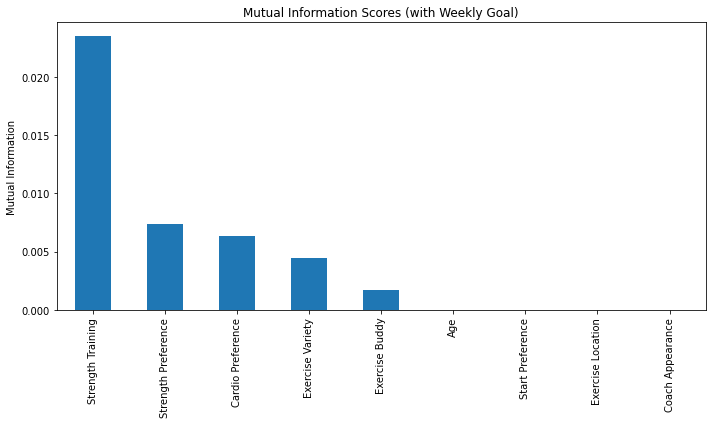

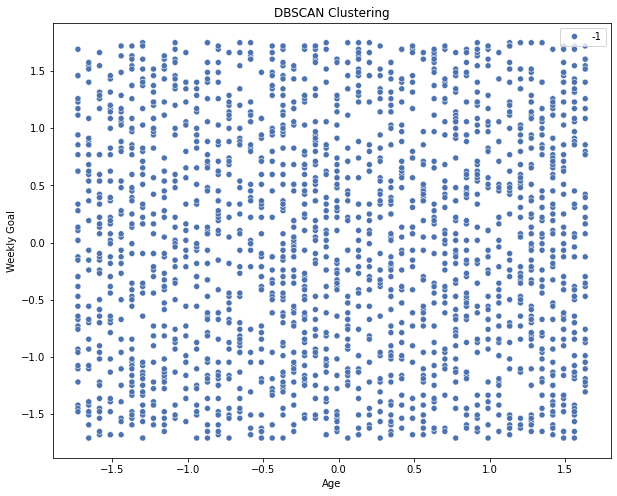

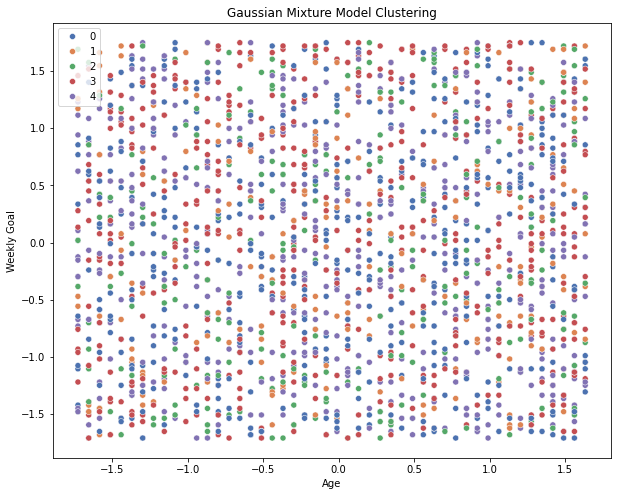

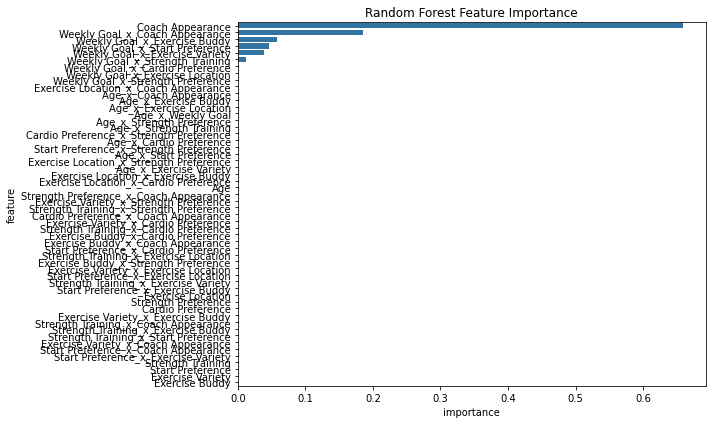


Personalized Recommendations:
Predicted Weekly Goal: 0.39
Top Important Features:
- Coach Appearance
- Weekly Goal_x_Coach Appearance
- Weekly Goal_x_Exercise Buddy
- Weekly Goal_x_Start Preference
- Weekly Goal_x_Exercise Variety


/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture

# Assuming synthetic_data_for_recsys is your DataFrame
numeric_data = synthetic_data[['Age', 'Weekly Goal', 'Strength Training', 'Start Preference', 
                     'Exercise Variety', 'Exercise Location', 'Exercise Buddy', 
                     'Cardio Preference', 'Strength Preference', 'Coach Appearance']]

# 1. Normalize Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_data.columns)

# 2. Non-linear Relationships: Mutual Information
def compute_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Compute MI scores for each feature with respect to 'Weekly Goal'
mi_scores = compute_mi_scores(scaled_df.drop('Weekly Goal', axis=1), scaled_df['Weekly Goal'])

plt.figure(figsize=(10, 6))
mi_scores.plot.bar()
plt.title('Mutual Information Scores (with Weekly Goal)')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

# 3. Feature Engineering: Interaction Features
for i in range(len(numeric_data.columns)):
    for j in range(i+1, len(numeric_data.columns)):
        col1, col2 = numeric_data.columns[i], numeric_data.columns[j]
        scaled_df[f'{col1}_x_{col2}'] = scaled_df[col1] * scaled_df[col2]

# 4. Advanced Clustering: DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_df)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=scaled_df.iloc[:, 0], y=scaled_df.iloc[:, 1], hue=dbscan_labels, palette='deep')
plt.title('DBSCAN Clustering')
plt.show()

# 5. Advanced Clustering: Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(scaled_df)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=scaled_df.iloc[:, 0], y=scaled_df.iloc[:, 1], hue=gmm_labels, palette='deep')
plt.title('Gaussian Mixture Model Clustering')
plt.show()

# 6. Ensemble Method: Random Forest for Feature Importance
X = scaled_df.drop('Weekly Goal', axis=1)
y = scaled_df['Weekly Goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# 7. Personalized Recommendation System (Basic Example)
def get_personalized_recommendation(user_profile, rf_model):
    user_features = user_profile.drop('Weekly Goal')
    predicted_goal = rf_model.predict(user_features.values.reshape(1, -1))[0]
    
    recommendations = {
        'Predicted Weekly Goal': predicted_goal,
        'Top Important Features': feature_importance['feature'].head().tolist()
    }
    return recommendations

# Example usage
user_index = 0  # Choose a user to get recommendations for
user_profile = scaled_df.iloc[user_index]
recommendations = get_personalized_recommendation(user_profile, rf_model)

print("\nPersonalized Recommendations:")
print(f"Predicted Weekly Goal: {recommendations['Predicted Weekly Goal']:.2f}")
print("Top Important Features:")
for feature in recommendations['Top Important Features']:
    print(f"- {feature}")

In [11]:
from sklearn.cluster import KMeans

# Initialize K-means with number of clusters
num_clusters = 5  # For demonstration, choose 3 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit K-means clustering model
kmeans.fit(numeric_data)

KMeans(n_clusters=5, random_state=42)

In [13]:
# Add cluster labels to the original dataset
synthetic_data['Cluster'] = kmeans.labels_

# Display cluster centers (centroid values)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=numeric_data.columns)
print("\nCluster Centers:")
print(cluster_centers)

# Analyze the distribution of clusters
cluster_counts = synthetic_data['Cluster'].value_counts()
print("\nCluster Counts:")
print(cluster_counts)



Cluster Centers:
         Age  Weekly Goal  Strength Training  Start Preference  \
0  38.597458   103.961864           0.512712          0.493644   
1  52.788301   170.412256           0.481894          0.498607   
2  39.173302   196.196721           0.466042          0.477752   
3  52.081152   130.633508           0.528796          0.500000   
4  29.250000   152.061111           0.461111          0.530556   

   Exercise Variety  Exercise Location  Exercise Buddy  Cardio Preference  \
0          0.487288           1.506356        0.508475           1.408898   
1          0.493036           1.548747        0.543175           1.540390   
2          0.508197           1.473068        0.482436           1.529274   
3          0.492147           1.531414        0.468586           1.494764   
4          0.505556           1.394444        0.508333           1.480556   

   Strength Preference  Coach Appearance  
0             2.569915          1.029661  
1             2.495822          0.99

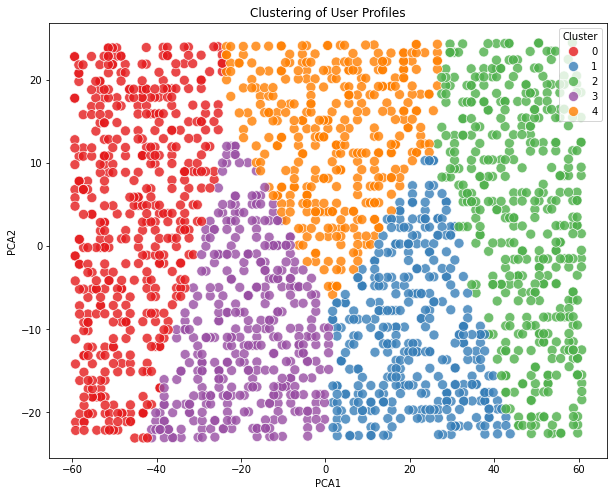

In [15]:
# Example: PCA for visualization (reduce to 2 dimensions)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
numeric_data_pca = pca.fit_transform(numeric_data)

# Add PCA components to the DataFrame
synthetic_data['PCA1'] = numeric_data_pca[:, 0]
synthetic_data['PCA2'] = numeric_data_pca[:, 1]

# Plot clusters based on PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=synthetic_data, palette='Set1', s=100, alpha=0.8)
plt.title('Clustering of User Profiles')
plt.legend(title='Cluster', loc='upper right')
plt.show()


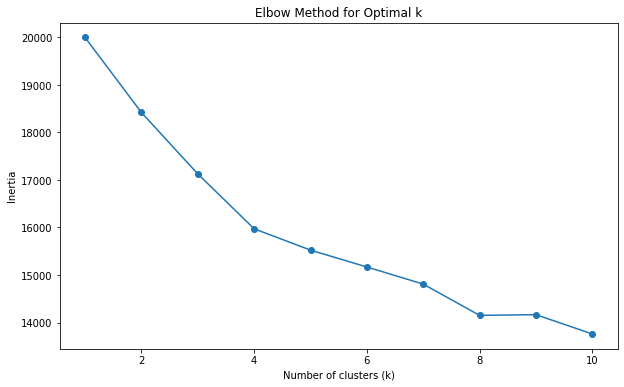

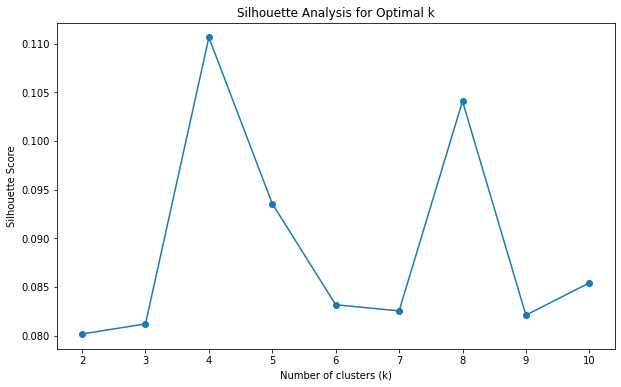

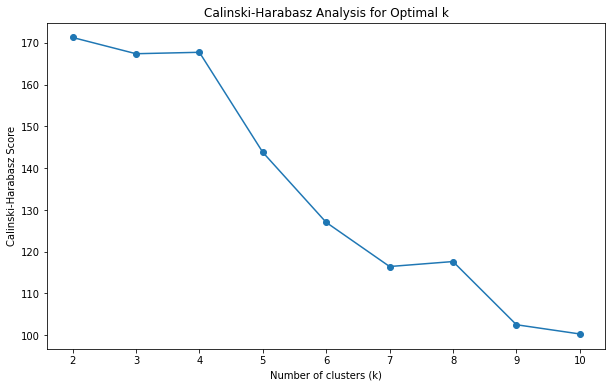

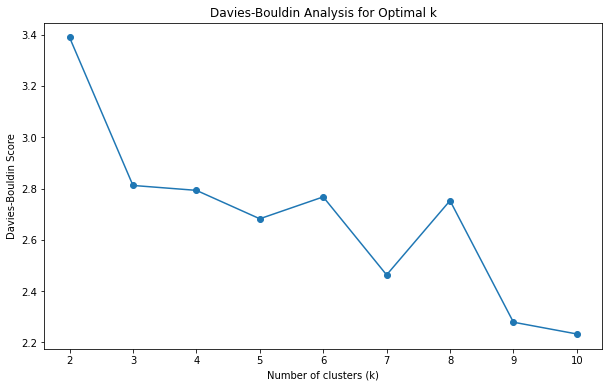

Evaluation metrics for 5 clusters:
Silhouette Score: 0.0935
Calinski-Harabasz Score: 143.8052
Davies-Bouldin Score: 2.6821


In [16]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming synthetic_data_for_recsys is your DataFrame and numeric_data contains the features for clustering

# 1. Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# 2. Elbow Method
def elbow_method(data, max_k):
    inertias = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k+1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

elbow_method(scaled_data, 10)

# 3. Silhouette Analysis
def silhouette_analysis(data, max_k):
    silhouette_scores = []
    for k in range(2, max_k+1):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k+1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.show()

silhouette_analysis(scaled_data, 10)

# 4. Calinski-Harabasz Index
def calinski_harabasz_analysis(data, max_k):
    ch_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        ch_score = calinski_harabasz_score(data, cluster_labels)
        ch_scores.append(ch_score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k+1), ch_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Analysis for Optimal k')
    plt.show()

calinski_harabasz_analysis(scaled_data, 10)

# 5. Davies-Bouldin Index
def davies_bouldin_analysis(data, max_k):
    db_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        db_score = davies_bouldin_score(data, cluster_labels)
        db_scores.append(db_score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k+1), db_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Analysis for Optimal k')
    plt.show()

davies_bouldin_analysis(scaled_data, 10)

# 6. Evaluate the chosen number of clusters
chosen_k = 5  # Replace with the optimal k you've determined
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

print(f"Evaluation metrics for {chosen_k} clusters:")
print(f"Silhouette Score: {silhouette_score(scaled_data, cluster_labels):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(scaled_data, cluster_labels):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(scaled_data, cluster_labels):.4f}")